<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_BiLSTM-len64_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

In [40]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [41]:
PATH_CLEANED_DATASET = 'data_cleaned_RU_merge_2ch_and_ok.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [42]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
174021,самый хороший это кошка не кот ленивый именно ...,0
193493,котяр респект,0
64585,жажда только на минск,0
113701,великолепие природа,0
171544,кто нибыть это разобраться для проба поставить...,0
196842,умный волысый покинуть дурной голова,0
105534,молодец талант ты умничка,0
137525,ты опять себя козломордый,1
238884,и через кольчугинский,0
62168,с день рождение какой ты красивый,0


In [43]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 75.5010886860397


max:  890
min:  0
mean:  11.992447716423932


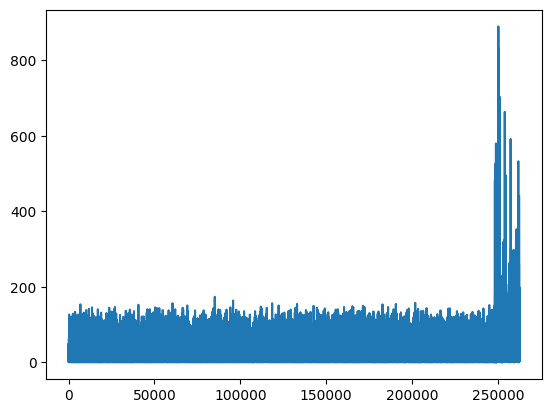

In [44]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [45]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [46]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(210161,)
(26270,)
(26271,)


In [47]:
# X_train=X_train[:10]
# y_train=y_train[:10]
# X_val=X_val[:10]
# y_val=y_val[:10]
# X_test=X_test[:10]
# y_test=y_test[:10]

In [48]:
X_train.shape

(210161,)

In [49]:
type(X_train)

numpy.ndarray

In [50]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [51]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [52]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

**Анализ датасета**

https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/src/dataset_analysis.ipynb

In [53]:
sequence_length=64

In [54]:
navec.get('<unk>').shape[0]

300

In [55]:
# X_train = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_train.flatten()
#     )
# ))

# X_val = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_val.flatten()
#     )
# ))

# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))


In [56]:
X_train.shape

(210161,)

**Build RNN model**

Model: "Glove-Navec_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_1 (Spatia  (None, 64, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64, 512)          1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                

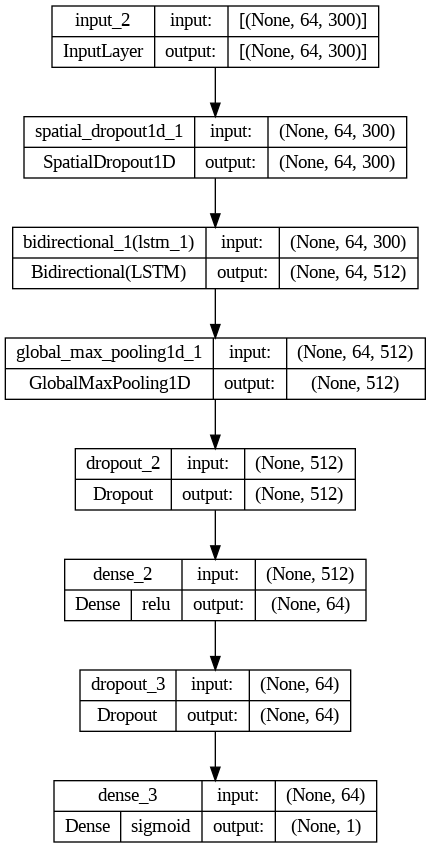

In [57]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
EPOCHS = 21
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_BiLSTM'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [58]:
import math
class Dataset(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.x))
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        ###################

        batch_x = np.array(list(map(
            lambda sentence:vectorize_sentence(
                sentence,
                vectorizer=navec,
                unc_token =NAVEC_UNK,
                pad_token = NAVEC_PAD,
                max_sequence_length=sequence_length),
            batch_x.ravel()
            )
        ))

        ###################

        return batch_x, batch_y

In [59]:
train_gen = Dataset(x_set=X_train,y_set=y_train,batch_size=BATCH_SIZE)

val_gen = Dataset(x_set=X_val,y_set=y_val,batch_size=BATCH_SIZE)
x,y = train_gen.__getitem__(1)

In [60]:
x.shape

(512, 64, 300)

In [61]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

# history = model.fit(
#     x=X_train,
#     y=y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_val,y_val),
#     callbacks=[early_stopping],
#     class_weight=calculate_weights(neutral_count, negative_count),
# )
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/21
411/411 [==============================] - 307s 732ms/step - loss: 0.2848 - tp: 33658.0000 - fp: 18189.0000 - tn: 152560.0000 - fn: 5754.0000 - accuracy: 0.8861 - precision: 0.6492 - recall: 0.8540 - auc: 0.9506 - prc: 0.8583 - val_loss: 0.1933 - val_tp: 4322.0000 - val_fp: 1345.0000 - val_tn: 19961.0000 - val_fn: 643.0000 - val_accuracy: 0.9243 - val_precision: 0.7627 - val_recall: 0.8705 - val_auc: 0.9722 - val_prc: 0.9176
Epoch 2/21
411/411 [==============================] - 277s 672ms/step - loss: 0.2259 - tp: 35215.0000 - fp: 14798.0000 - tn: 155951.0000 - fn: 4197.0000 - accuracy: 0.9096 - precision: 0.7041 - recall: 0.8935 - auc: 0.9691 - prc: 0.9016 - val_loss: 0.2042 - val_tp: 4520.0000 - val_fp: 1847.0000 - val_tn: 19459.0000 - val_fn: 445.0000 - val_accuracy: 0.9128 - val_precision: 0.7099 - val_recall: 0.9104 - val_auc: 0.9751 - val_prc: 0.9234
Epoch 3/21
411/411 [==============================] - 280s 680ms/step - loss: 0.2093 - tp: 35523.0000 - fp: 13760.0000 -

**Save model**

In [62]:
model.save(MODEL_NAME)

In [63]:
# X_test = np.array(list(map(
#     lambda sentence:vectorize_sentence(
#         sentence,
#         vectorizer=navec,
#         unc_token =NAVEC_UNK,
#         pad_token = NAVEC_PAD,
#         max_sequence_length=sequence_length),
#     X_test.flatten()
#     )
# ))

In [64]:
test_gen = Dataset(x_set=X_test,y_set=y_test,batch_size=BATCH_SIZE)

In [65]:
pred = model.predict(test_gen).flatten()

52/52 [==============================] - 11s 202ms/step


In [66]:
pred

array([1.8867482e-05, 4.4811982e-06, 6.1079096e-02, ..., 1.3283731e-06,
       2.5785592e-04, 5.0968760e-01], dtype=float32)

In [67]:
pred

array([1.8867482e-05, 4.4811982e-06, 6.1079096e-02, ..., 1.3283731e-06,
       2.5785592e-04, 5.0968760e-01], dtype=float32)

In [68]:
# threshold =0.5
# pred = np.where(pred<threshold,0,1)

In [69]:
pred

array([1.8867482e-05, 4.4811982e-06, 6.1079096e-02, ..., 1.3283731e-06,
       2.5785592e-04, 5.0968760e-01], dtype=float32)

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  predictions = np.where(predictions <p,0,1)
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 21})
  plt.rc('axes', titlesize=16)
  plt.rc('axes', labelsize=14)
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  # plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(labels, predictions)))
  print("Recall: {0:.2f} %".format(100 * recall_score(labels, predictions)))
  print("Precision: {0:.2f} %".format(100 * precision_score(labels, predictions)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(labels, predictions)))  
  precision, recall, f1score = precision_recall_fscore_support(labels, predictions, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(labels, predictions,digits=4))
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 92.68 %
Recall: 91.97 %
Precision: 75.41 %
F1-score: 82.87 % 

precision: 0.8669314153481035, recall: 0.924106042374333, f1score: 0.8910777291527668
              precision    recall  f1-score   support

           0     0.9798    0.9285    0.9535     21216
           1     0.7541    0.9197    0.8287      5054

    accuracy                         0.9268     26270
   macro avg     0.8669    0.9241    0.8911     26270
weighted avg     0.9364    0.9268    0.9295     26270

True Negatives:  19700
False Positives:  1516
False Negatives:  406
True Positives:  4648


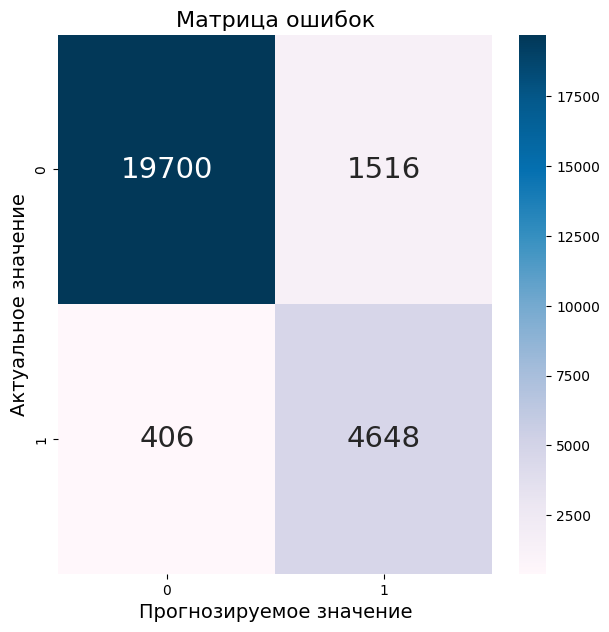

In [71]:
plot_cm(y_test, pred)

In [72]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

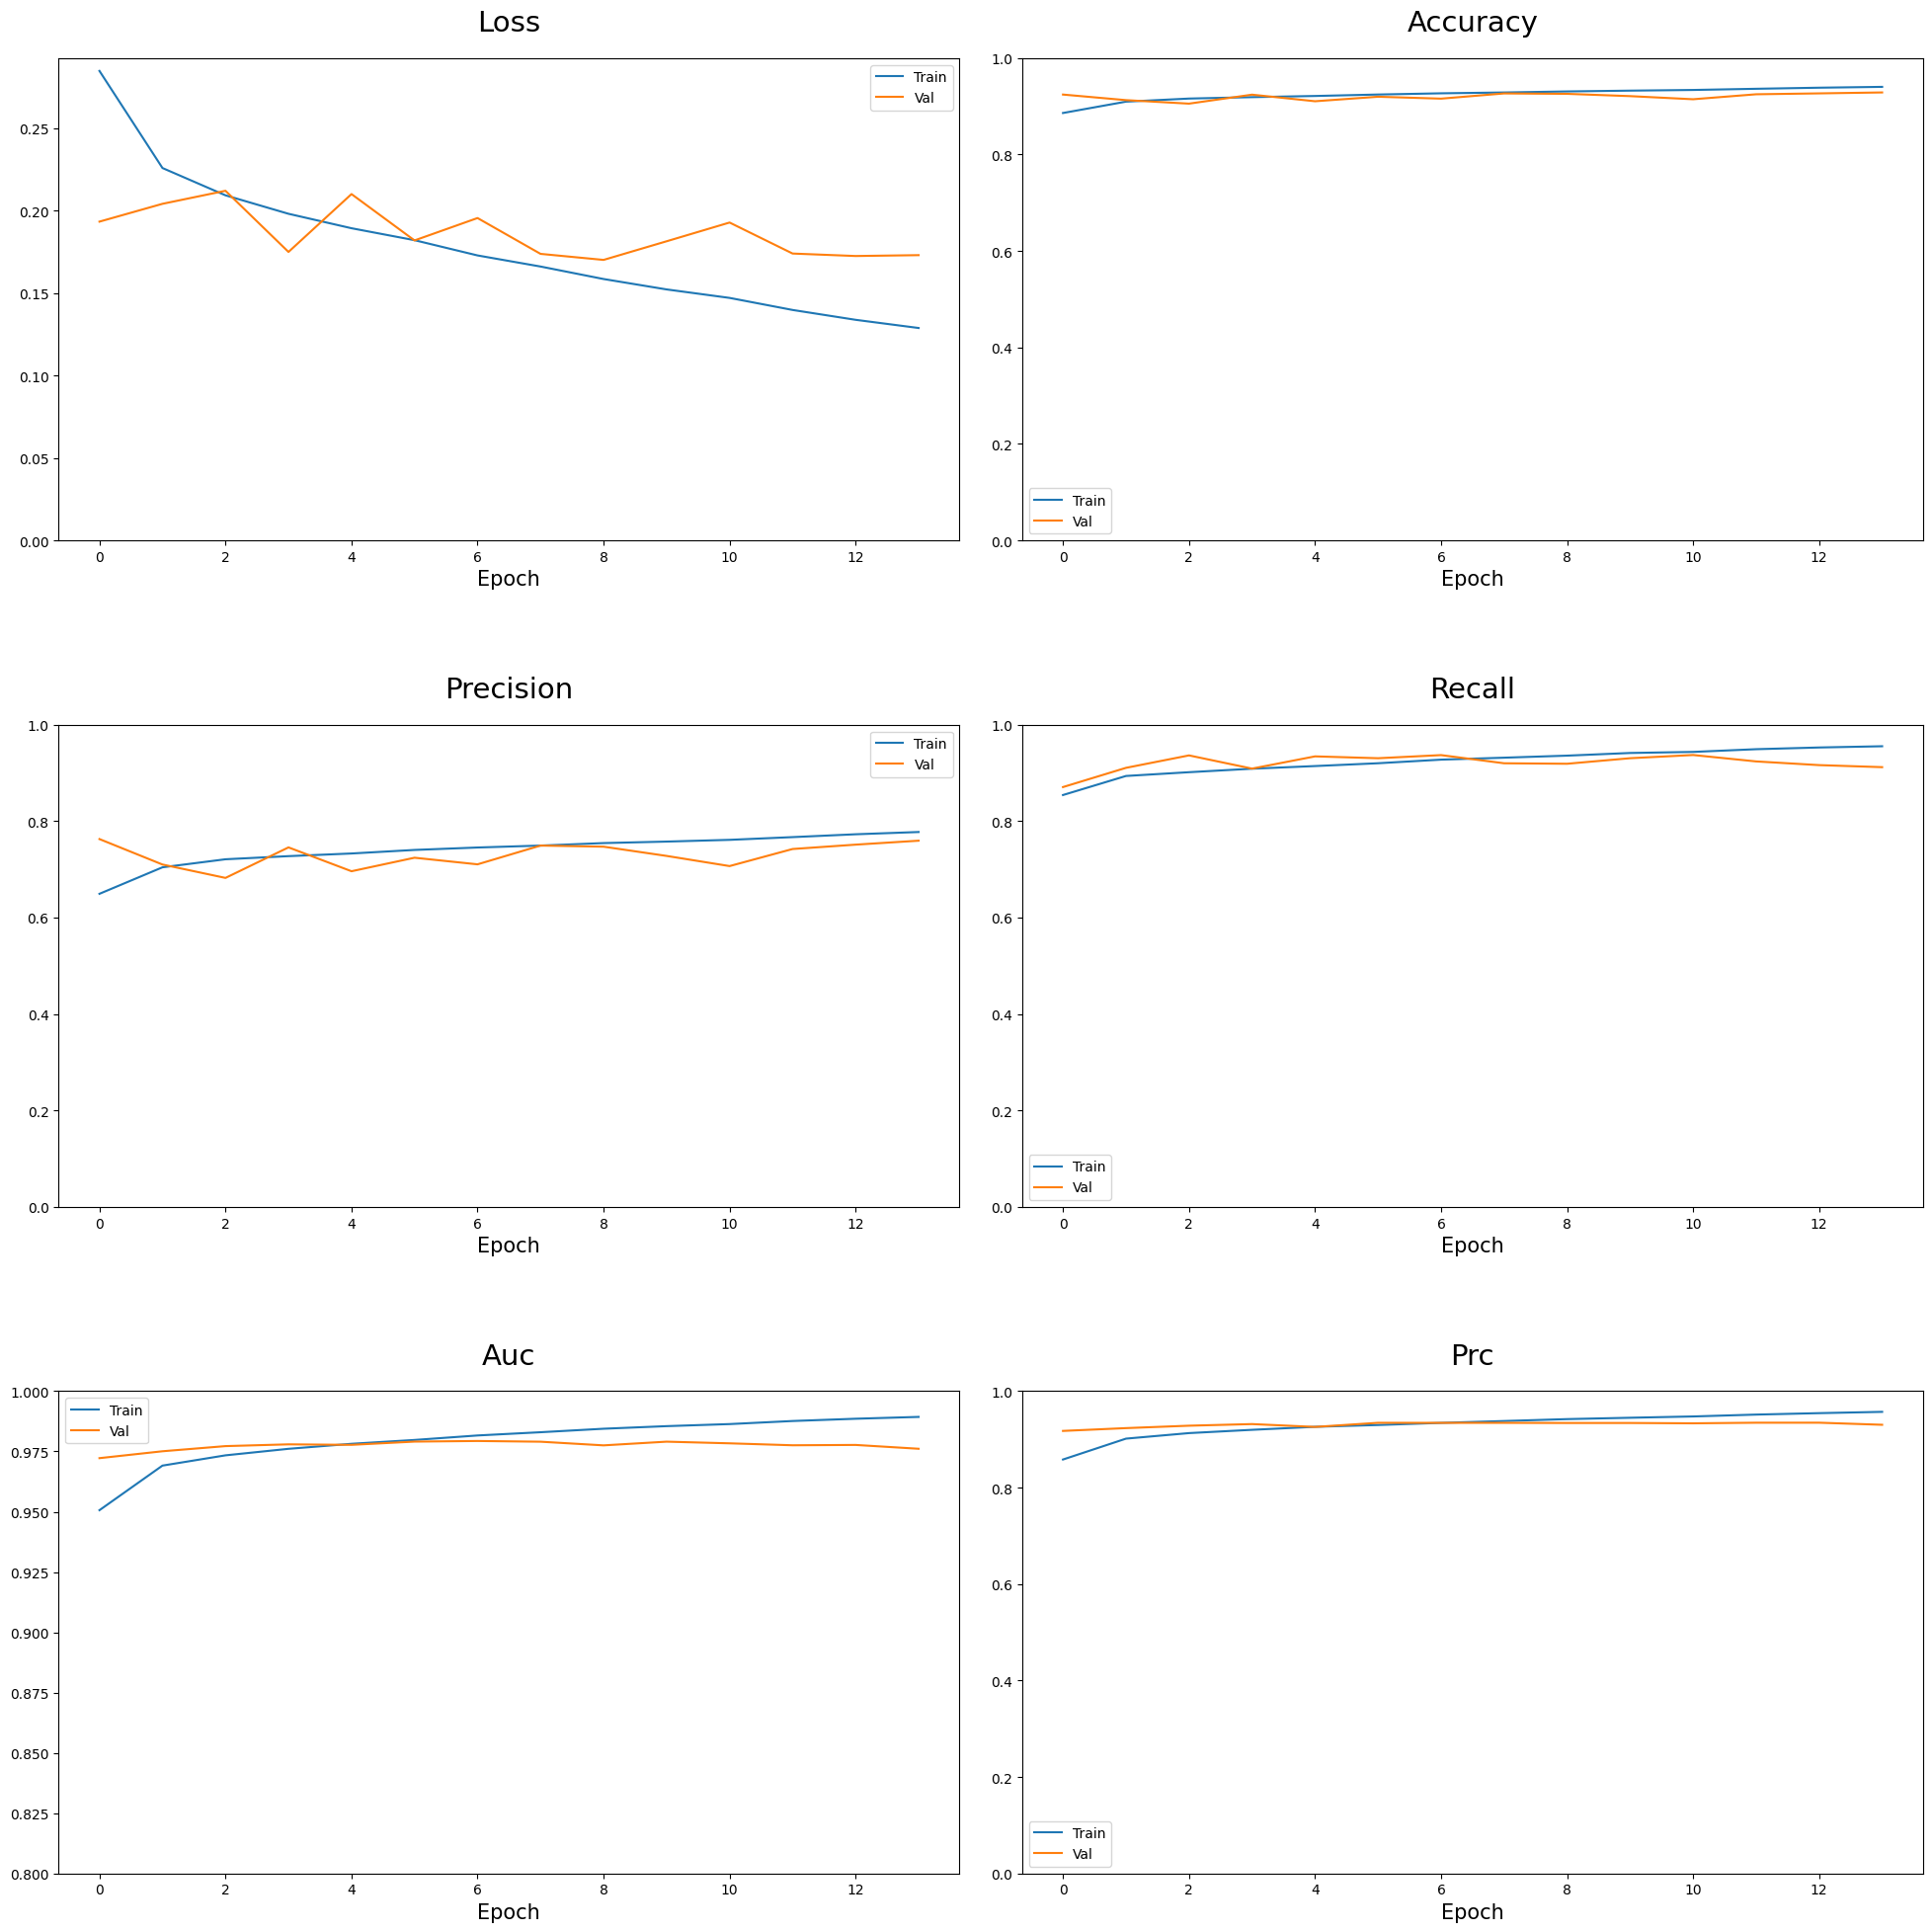

In [73]:
plot_metrics(history)

**Show ROC - curve**

: ROC AUC=0.981
treshold
[1.9999998e+00 9.9999976e-01 9.9999964e-01 ... 5.9315386e-10 5.9233529e-10
 4.9859751e-14]


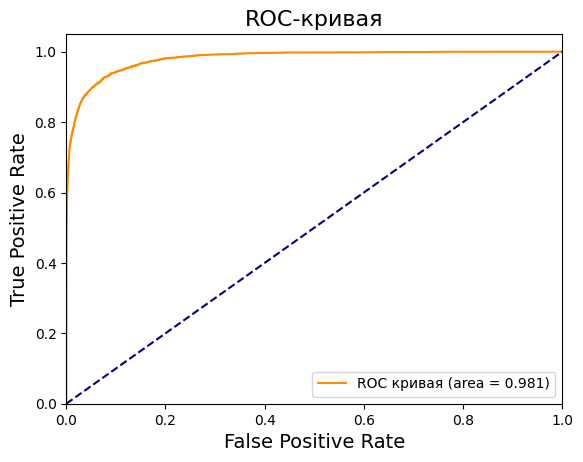

Best F1-Score:  0.8659257034144389
Best threshold:  0.7244892
Accuracy: 94.90 %
Recall: 85.56 %
Precision: 87.65 %
F1-score: 86.59 % 

precision: 0.9211664214425592, recall: 0.9134276006908197, f1score: 0.9172295309072758
              precision    recall  f1-score   support

           0     0.9658    0.9713    0.9685     21216
           1     0.8765    0.8556    0.8659      5054

    accuracy                         0.9490     26270
   macro avg     0.9212    0.9134    0.9172     26270
weighted avg     0.9486    0.9490    0.9488     26270

True Negatives:  20607
False Positives:  609
False Negatives:  730
True Positives:  4324


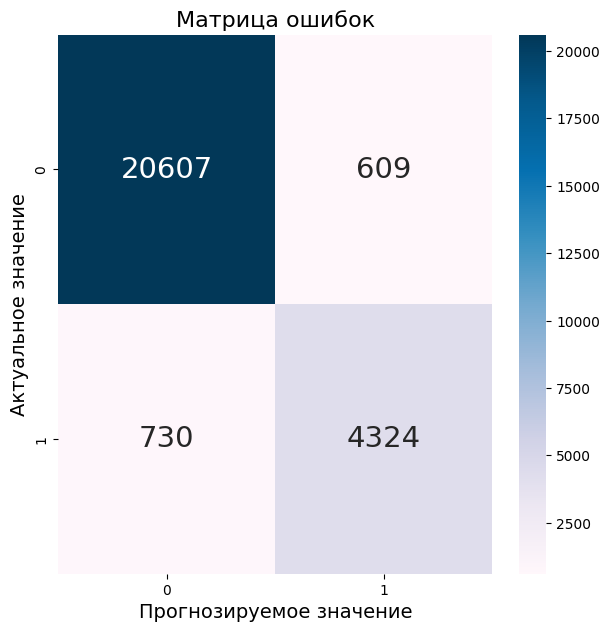

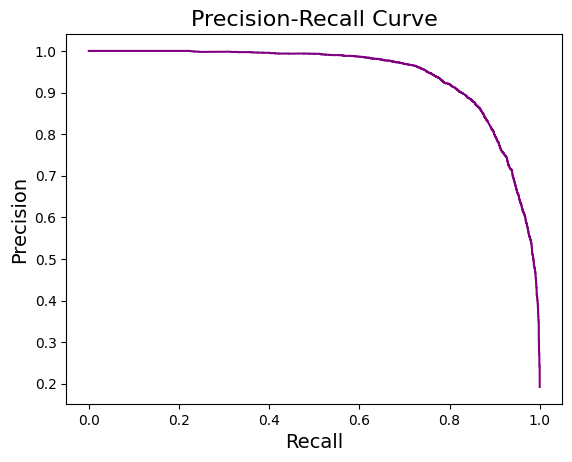

In [74]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
# сохраняем вероятности только для положительного исхода
lr_probs = pred

# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

print('treshold')
print(treshold)

# размеры шрифта
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# строим график
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right",)
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, lr_probs)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
max_f1_thresh = thresholds[np.argmax(f1_scores)]
print('Best F1-Score: ',max_f1)
print('Best threshold: ',max_f1_thresh)
plot_cm(y_test,lr_probs, p=max_f1_thresh)
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [75]:
!nvidia-smi

Thu Apr 27 12:49:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    31W /  70W |   2665MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [76]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
antiinterupt=78+90